# Assessing Airline Reliability And Airport Trends

In our previous project, we ranked airlines based on what their 2015 delay and cancellation trends were. The goal of this project is to follow up on that analysis with consideration for the distance of the flights. In addition to airlines, we will also be diving into trends of the busiest domestic airports to understand what delays and cancellations look like at high traffic locations.

Dateset Source: https://www.kaggle.com/usdot/flight-delays <BR>
Original Source: U.S. Department of Transportation's (DOT) Bureau of Transportation Statistics https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236

In [1]:
# Imports we will be working with
import pandas as pd
from IPython.display import display
from IPython.display import Pretty as disp
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from google.cloud import bigquery
client = bigquery.Client()
pd.options.display.max_columns = None # To see all the columns of our table
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier

class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

## I. A Glimpse at the Raw Data

- [x] I. A Glimpse at the Raw Data
- [ ] II. Data Pre-Processing
- [ ] III. Delays (By Airline)
- [ ] IV. Cancellations (By Airline)
- [ ] V. Identifying Busy Airports
- [ ] VI. Delays (By Airport)
- [ ] VII. Cancellations (By Airport)
- [ ] VIII. Taxiing (By Airport)
- [ ] IX. Correlation Heatmap
- [ ] X. Machine Learning

#### Table 1: Flights

In [9]:
original = """
SELECT * 
FROM `ba780-team-1b.flights.flights_original` 
"""
original_data = client.query(original).to_dataframe()
original_data.head(3)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,9,13,7,AS,126,N513AS,FAI,SEA,630,623.0,-7.0,10.0,633.0,212.0,208.0,192.0,1533,1045.0,6.0,1102,1051.0,-11.0,0,0,None,NaN,NaN,NaN,NaN,NaN
1,2015,9,13,7,EV,2631,N680AE,DFW,SHV,845,841.0,-4.0,14.0,855.0,60.0,54.0,33.0,190,928.0,7.0,945,935.0,-10.0,0,0,None,NaN,NaN,NaN,NaN,NaN
2,2015,9,13,7,AA,1712,N177US,SAN,PHX,1230,1219.0,-11.0,11.0,1230.0,75.0,70.0,51.0,304,1321.0,8.0,1345,1329.0,-16.0,0,0,None,NaN,NaN,NaN,NaN,NaN


#### Table 2: Airports

In [3]:
original_airport = """
SELECT *
FROM `ba780-team-1b.flights.airports`
"""
original_airports = client.query(original_airport).to_dataframe()
original_airports.head(3)

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ADK,Adak Airport,Adak,AK,USA,51.87796,-176.64603
1,ADQ,Kodiak Airport,Kodiak,AK,USA,57.74997,-152.49386
2,AKN,King Salmon Airport,King Salmon,AK,USA,58.67680,-156.64922


#### Table 3: Airlines

In [8]:
original_airline = """
SELECT *
FROM `ba780-team-1b.flights.airlines`
"""
original_airlines = client.query(original_airline).to_dataframe()
original_airlines.head(3)

,IATA_Code,Airline
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.


#### Table 4 & 5: Airport Codes

In our last project, a lot of the airport codes were discarded due to their unidentifiable nature. However, thanks to a Kaggle user's tutorial here: https://www.kaggle.com/srcole/fix-inconsistent-airport-codes, we were able to properly map out the correct IATA codes with the following datasets from the Bureau of Transportation:

In [14]:
IATA = """
SELECT * 
FROM `ba780-team-1b.flights.Airport IATA Code` 
"""
IATA_codes = client.query(IATA).to_dataframe()


five_char = """
SELECT *
FROM `ba780-team-1b.flights.Airport 5-char ID` 
"""
five_char_ID = client.query(five_char).to_dataframe()


display('IATA_codes.head(3)', 'five_char_ID.head(3)')

,Code,Description
0,CBK,"Colby, KS: Murray"
1,ANP,"Annapolis, MD: Lee"
2,KCA,"Kuqa, China: Kuche"
,Code,Description
0,10892,"Colby, KS: Murray"
1,10309,"Annapolis, MD: Lee"
2,12632,"Kuqa, China: Kuche"


## II. Data Pre-Processing

- [x] I. A Glimpse at the Raw Data
- [x] II. Data Pre-Processing
- [ ] III. Delays (By Airline)
- [ ] IV. Cancellations (By Airline)
- [ ] V. Identifying Busy Airports
- [ ] VI. Delays (By Airport)
- [ ] VII. Cancellations (By Airport)
- [ ] VIII. Taxiing (By Airport)
- [ ] IX. Correlation Heatmap
- [ ] X. Machine Learning

#### 1.) Fixing airport codes

As previously mentioned in Section I, we followed a Kaggle notebook's tutorial on how to replace the 5 charcter airport codes with identifiable IATA codes. Below is the code provided by the author. Essentially, the code first merges the two dataframes containing IATA and 5-digit codes which is then converted to a dictionary before proceeding to iterate through the Flights dataset. The loop checks to see if the airport names are 3 characters in length, and if not, will be replaced with the correct value from the code dictionary. 

In [ ]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
sns.set_style('white')

df_aircode1 = pd.read_csv('L_AIRPORT.csv')
df_aircode2 = pd.read_csv('L_AIRPORT_ID.csv')

df_aircode1 = df_aircode1.reset_index()
df_aircode2 = df_aircode2.reset_index()
df_aircodes = pd.merge(df_aircode1,df_aircode2,on='Description')
aircode_dict = dict(zip(df_aircodes['Code_y'].astype(str),df_aircodes['Code_x']))

df_fl = pd.io.parsers.read_csv('flights-Copy1.csv')

# Make sure all Origin and departing airports are strings
df_fl['ORIGIN_AIRPORT'] = df_fl['ORIGIN_AIRPORT'].values.astype(str)
df_fl['DESTINATION_AIRPORT'] = df_fl['DESTINATION_AIRPORT'].values.astype(str)

N_flights = len(df_fl)
for i in range(N_flights):
    if i % 100000 == 0:
        print(i)
    if len(df_fl['ORIGIN_AIRPORT'][i]) != 3:
        to_replace = df_fl['ORIGIN_AIRPORT'][i]
        value = aircode_dict[df_fl['ORIGIN_AIRPORT'][i]]
        df_fl = df_fl.replace(to_replace, value)
        print('replaced',to_replace,'with',value)
    elif len(df_fl['DESTINATION_AIRPORT'][i]) != 3:
        to_replace = df_fl['DESTINATION_AIRPORT'][i]
        value = aircode_dict[df_fl['DESTINATION_AIRPORT'][i]]
        df_fl = df_fl.replace(to_replace, value)
        print('replaced',to_replace,'with',value)
        
df_fl.to_csv('flights-airport-fix.csv',index = False)

#### 2.) Cleaning up the data

Following the correction of airport codes, we took over the rest of the data pre-processing. All dates and times were converted to date_time objects and the dataset was split into 2: delays & cancellations. Due to the large size of the data, the most convenient method of accessing it was through BigQuery. All data was uploaded to a bucket on Google Cloud Platform for simple querying on AI Platform.

In [ ]:
flights = pd.read_csv('flights-airport-fix.csv')
flights['SCHEDULED_DEPARTURE'] = flights['SCHEDULED_DEPARTURE'].apply('{:0>4}'.format)
flights['SCHEDULED_DEPARTURE']=pd.to_datetime(flights.SCHEDULED_DEPARTURE, format='%H%M').dt.time
flights['DATE'] = pd.to_datetime(flights[['YEAR','MONTH','DAY']])
date_col = flights.pop('DATE')
flights.insert(0, 'DATE', date_col)
del flights['YEAR']
del flights['MONTH']
del flights['DAY']


delays = flights[(flights['DEPARTURE_TIME'].notnull()) & (flights['ARRIVAL_TIME'].notnull())].copy()
delays['DEPARTURE_TIME'] = delays['DEPARTURE_TIME'].astype('Int64')
delays['DEPARTURE_TIME'] = delays['DEPARTURE_TIME'].apply('{:0>4}'.format)
delays['DEPARTURE_TIME'] = delays['DEPARTURE_TIME'].apply(lambda x: str(x).zfill(4))
delays.DEPARTURE_TIME = delays.DEPARTURE_TIME.str[:2] + ':' + delays.DEPARTURE_TIME.str[-2:]
delays.loc[(delays.DEPARTURE_TIME == '24:00'), 'DEPARTURE_TIME'] = '00:00'
delays['DEPARTURE_TIME'] = pd.to_datetime(delays.DEPARTURE_TIME, format='%H:%M').dt.time

delays['SCHEDULED_ARRIVAL'] = delays['SCHEDULED_ARRIVAL'].apply('{:0>4}'.format)
delays.SCHEDULED_ARRIVAL = delays.SCHEDULED_ARRIVAL.str[:2] + ':' + delays.SCHEDULED_ARRIVAL.str[-2:]
delays.loc[(delays.SCHEDULED_ARRIVAL == '24:00'), 'SCHEDULED_ARRIVAL'] = '00:00'
delays['SCHEDULED_ARRIVAL'] = pd.to_datetime(delays.SCHEDULED_ARRIVAL, format='%H:%M').dt.time

delays['ARRIVAL_TIME'] = delays['ARRIVAL_TIME'].astype('Int64')
delays['ARRIVAL_TIME'] = delays['ARRIVAL_TIME'].apply('{:0>4}'.format)
delays.ARRIVAL_TIME = delays.ARRIVAL_TIME.str[:2] + ':' + delays.ARRIVAL_TIME.str[-2:]
delays.loc[(delays.ARRIVAL_TIME == '24:00'), 'ARRIVAL_TIME'] = '00:00'
delays['ARRIVAL_TIME'] = pd.to_datetime(delays.ARRIVAL_TIME, format='%H:%M').dt.time

cancellations = flights[(flights['DEPARTURE_TIME'].isnull()) & (flights['ARRIVAL_TIME'].isnull())].copy()
cancellations['SCHEDULED_ARRIVAL'] = cancellations['SCHEDULED_ARRIVAL'].apply('{:0>4}'.format)
cancellations.SCHEDULED_ARRIVAL = cancellations.SCHEDULED_ARRIVAL.str[:2] + ':' + cancellations.SCHEDULED_ARRIVAL.str[-2:]
cancellations.loc[(cancellations.SCHEDULED_ARRIVAL == '24:00'), 'SCHEDULED_ARRIVAL'] = '00:00'
cancellations['SCHEDULED_ARRIVAL'] = pd.to_datetime(cancellations.SCHEDULED_ARRIVAL, format='%H:%M').dt.time

delays.to_csv('delays.csv', index=False)
cancellations.to_csv('cancellations.csv', index=False)

#### 3.) The outcome

Below are the two main tables we queried off of for our analysis:

In [2]:
delay = """
SELECT *
FROM `ba780-team-1b.flights.delays`
"""
delays = client.query(delay).to_dataframe()
delays.head(3)

,DATE,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015-01-05,1,AS,303,N791AS,SFO,SEA,10:10:00,10:09:00,-1.0,17.0,1026.0,122.0,139.0,99.0,679,1205.0,23.0,12:12:00,12:28:00,16.0,0,0,None,16.0,0.0,0.0,0.0,0.0
1,2015-01-05,1,MQ,2970,N638MQ,ORD,FAR,15:00:00,16:25:00,85.0,15.0,1640.0,113.0,114.0,95.0,557,1815.0,4.0,16:53:00,18:19:00,86.0,0,0,None,1.0,0.0,0.0,30.0,55.0
2,2015-08-31,1,MQ,3309,N6EAMQ,OKC,ORD,05:05:00,08:24:00,199.0,12.0,836.0,132.0,137.0,99.0,693,1015.0,26.0,07:17:00,10:41:00,204.0,0,0,None,5.0,0.0,90.0,0.0,109.0


In [6]:
cancellation = """
SELECT * 
FROM `ba780-team-1b.flights.cancellations` 
"""
cancellations = client.query(cancellation).to_dataframe()
cancellations.head(3)

,DATE,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015-01-08,4,EV,6168,N12569,ORD,ABE,18:25:00,None,None,None,None,113.0,None,None,654,None,None,21:18:00,None,None,0,1,C,None,None,None,None,None
1,2015-01-26,1,EV,6168,N13908,ORD,ABE,18:25:00,None,None,None,None,113.0,None,None,654,None,None,21:18:00,None,None,0,1,C,None,None,None,None,None
2,2015-02-14,6,EV,6168,N16559,ORD,ABE,19:35:00,None,None,None,None,107.0,None,None,654,None,None,22:22:00,None,None,0,1,B,None,None,None,None,None


## III. Delays (By Airline)

- [x] I. A Glimpse at the Raw Data
- [x] II. Data Pre-Processing
- [x] III. Delays (By Airline)
- [ ] IV. Cancellations (By Airline)
- [ ] V. Identifying Busy Airports
- [ ] VI. Delays (By Airport)
- [ ] VII. Cancellations (By Airport)
- [ ] VIII. Taxiing (By Airport)
- [ ] IX. Correlation Heatmap
- [ ] X. Machine Learning

#### 1.) What were the average departure delay times per airline?

It was brought to our attention in our last project that the duration/distance of a flight could have an impact on delays and cancellations. It's possible that an airline that primarily operates long distance flights may on average exhibit different delay/cancellation statistics when compared to short distance data. To incoporate this factor, we split the data by distance: anything equal to or below 800 miles was conisdered short distance while anything above 800 miles was considered long distance.

In [25]:
delays_with_name = airlines.merge(delays, left_on='IATA_Code', right_on='AIRLINE')

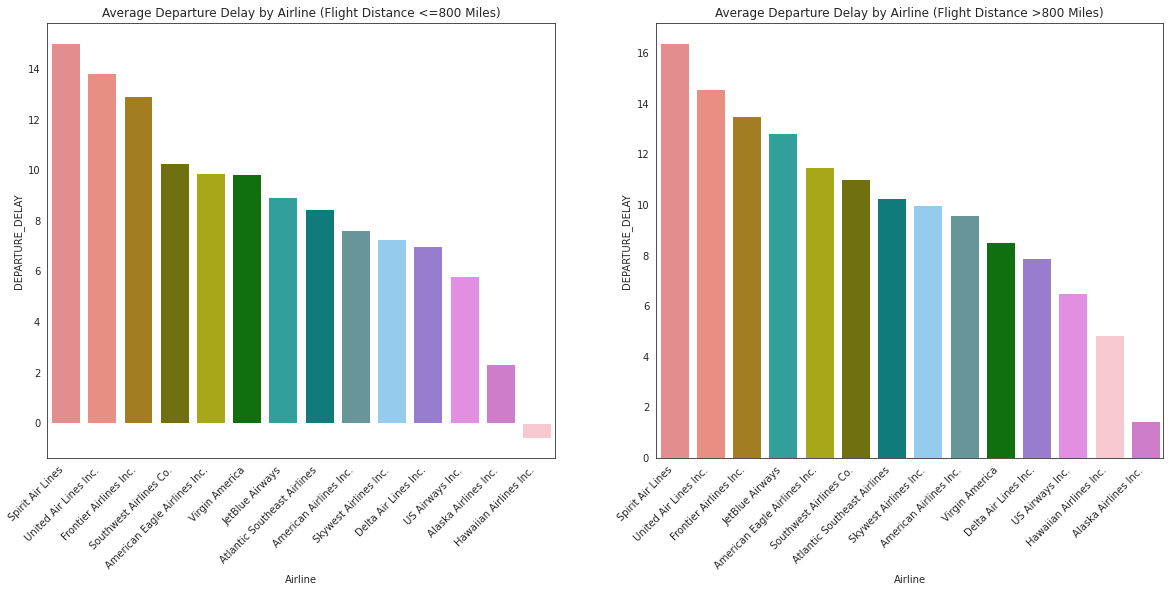

In [39]:
delay_less_800 = delays_with_name[delays_with_name['DISTANCE'] <= 800].groupby('Airline')[['DEPARTURE_DELAY']].mean()
delay_over_800 = delays_with_name[delays_with_name['DISTANCE'] > 800].groupby('Airline')[['DEPARTURE_DELAY']].mean()

color_map = {'United Air Lines Inc.':'salmon', 'American Airlines Inc.':'cadetblue' ,
       'US Airways Inc.':'violet' , 'Frontier Airlines Inc.':'darkgoldenrod', 'JetBlue Airways':'lightseagreen',
       'Skywest Airlines Inc.':'lightskyblue', 'Alaska Airlines Inc.':'orchid',
       'Spirit Air Lines':'lightcoral', 'Southwest Airlines Co.':'olive',
       'Delta Air Lines Inc.':'mediumpurple', 'Atlantic Southeast Airlines':'darkcyan',
       'Hawaiian Airlines Inc.':'pink', 'American Eagle Airlines Inc.':'y',
       'Virgin America':'g'}


fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.barplot(x="Airline", y="DEPARTURE_DELAY" , data=delay_less_800.reset_index().sort_values('DEPARTURE_DELAY', ascending=False), palette=color_map, ax=ax[0])
sns.barplot(x="Airline", y="DEPARTURE_DELAY" , data=delay_over_800.reset_index().sort_values('DEPARTURE_DELAY', ascending=False), palette=color_map, ax=ax[1])
ax[0].set_title('Average Departure Delay by Airline (Flight Distance <=800 Miles)')
ax[1].set_title('Average Departure Delay by Airline (Flight Distance >800 Miles)')
ax[0].set_xticklabels(ax[0].get_xticklabels(), horizontalalignment='right', rotation=45)
ax[1].set_xticklabels(ax[1].get_xticklabels(), horizontalalignment='right', rotation=45);

Spirit, United, and Frontier airlines all maintained their top 3 rankings in both categories. Aside from those airlines, we see some slight changes in rank such as JetBlue going from 7th place in the short distance category to 4th place in the long distance category. This makes sense as JetBlue mainly operates on coastal airports. Another example is Hawaiian airlines. For short distance flights, Hawaiian Airlines only operates between two airports within the state and are only 100 miles apart. Due to this short distance, operating that flight could be much more efficient than a 2000+ mile one, which would explain the variability between the airline's ranking in the plots. Thus, we can conclude that the distance of a flight is a factor we cannot neglect when analyzing an airline's delays.

#### 2.) What were the average arrival delay times per airline?

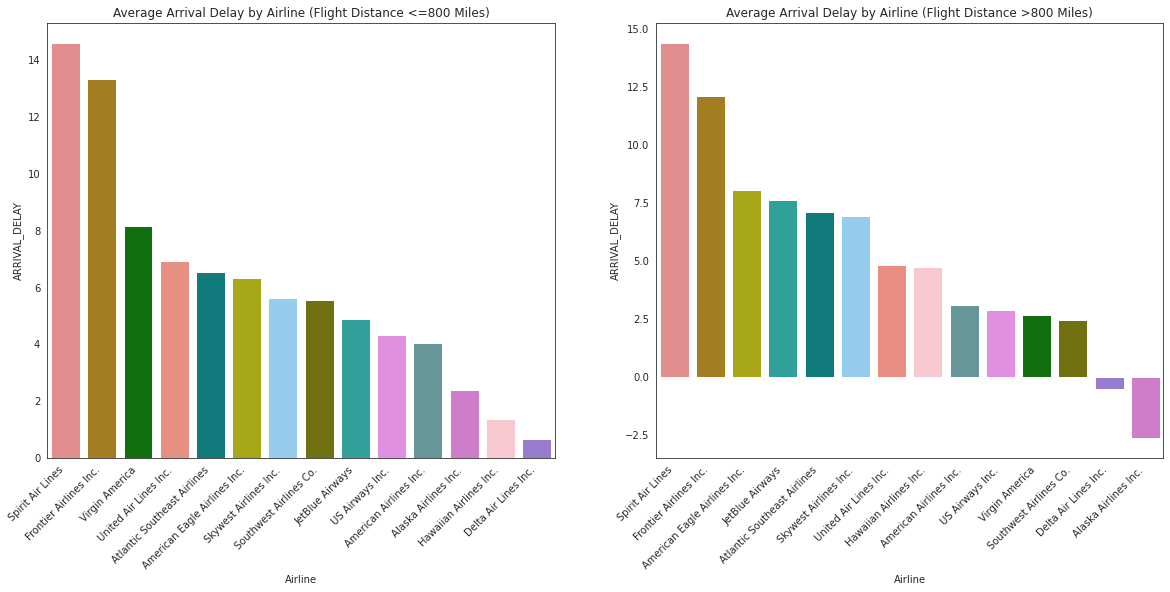

In [40]:
delay_less_800 = delays_with_name[delays_with_name['DISTANCE'] <= 800].groupby('Airline')[['ARRIVAL_DELAY']].mean()
delay_over_800 = delays_with_name[delays_with_name['DISTANCE'] > 800].groupby('Airline')[['ARRIVAL_DELAY']].mean()

fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.barplot(x="Airline", y="ARRIVAL_DELAY" , data=delay_less_800.reset_index().sort_values('ARRIVAL_DELAY', ascending=False), palette=color_map, ax=ax[0])
sns.barplot(x="Airline", y="ARRIVAL_DELAY" , data=delay_over_800.reset_index().sort_values('ARRIVAL_DELAY', ascending=False), palette=color_map, ax=ax[1])
ax[0].set_title('Average Arrival Delay by Airline (Flight Distance <=800 Miles)')
ax[1].set_title('Average Arrival Delay by Airline (Flight Distance >800 Miles)')
ax[0].set_xticklabels(ax[0].get_xticklabels(), horizontalalignment='right', rotation=45)
ax[1].set_xticklabels(ax[1].get_xticklabels(), horizontalalignment='right', rotation=45);

Compared to departure delay, we see a rather significant reshuffling of ranks between the short distance and long distance categories. Spirt and Frontier Airlines, however maintained their place in both. The most notable shift in rank was Virgin America, which was 3rd place in the short distance category but 11th place in the long distance category. While arrival delay usually has some correlation to departure delay, there are also other factors to consider such as origin airport congestion, flight speed, or weather conditions.

## IV. Cancellations (By Airline)

- [x] I. A Glimpse at the Raw Data
- [x] II. Data Pre-Processing
- [x] III. Delays (By Airline)
- [x] IV. Cancellations (By Airline)
- [ ] V. Identifying Busy Airports
- [ ] VI. Delays (By Airport)
- [ ] VII. Cancellations (By Airport)
- [ ] VIII. Taxiing (By Airport)
- [ ] IX. Correlation Heatmap
- [ ] X. Machine Learning

We've examined the relationship between flight distance and delays, now let's see how flight distance affects cancellations.

#### 1.) What were the cancellation percentges of each airline?

In [6]:
canc_data = """
SELECT *
FROM `ba780-team-1b.flights.cancellations`
WHERE DIVERTED = 0
"""
canc = client.query(canc_data).to_dataframe()

# Retrieve data from bigquery -- airlines
airlines = """
SELECT *
FROM `ba780-team-1b.flights.airlines`
"""
airlines = client.query(airlines).to_dataframe()

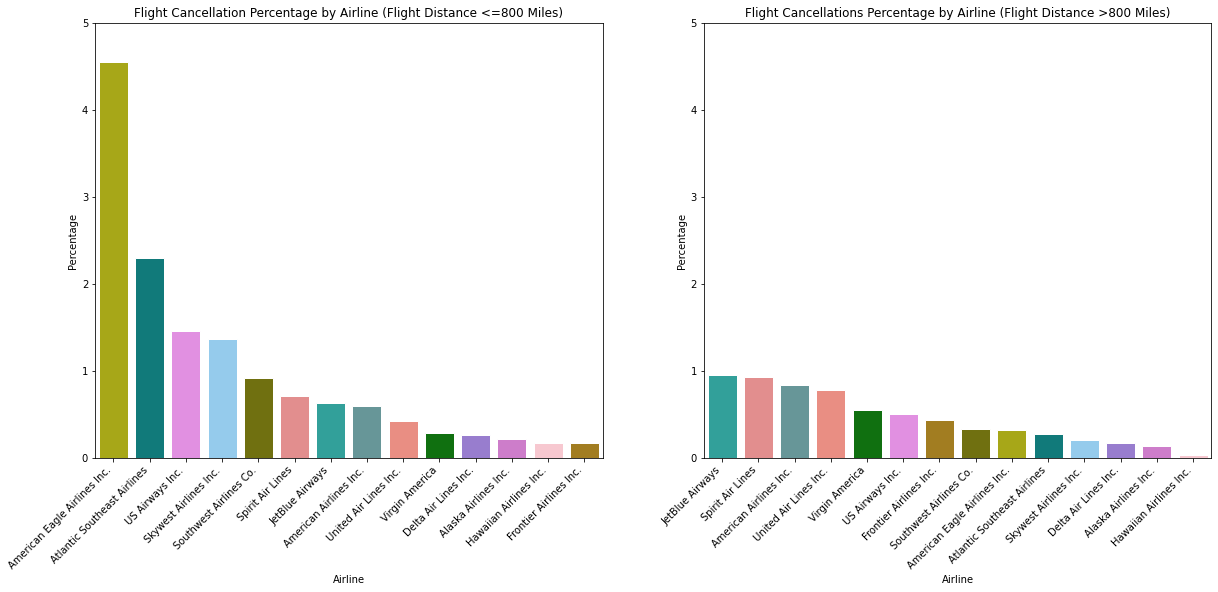

In [10]:
# Extract required data
canc_by_airline_800_less = canc[canc['DISTANCE'] <= 800].groupby(by='AIRLINE')['CANCELLED'].count()
canc_by_airline_800_less = pd.DataFrame({'Count':canc_by_airline_800_less})
canc_by_airline_800_over = canc[canc['DISTANCE'] > 800].groupby(by='AIRLINE')['CANCELLED'].count()
canc_by_airline_800_over = pd.DataFrame({'Count':canc_by_airline_800_over})
original_count = original_data.groupby('AIRLINE')[['FLIGHT_NUMBER']].count()

# Merge with airlines table to map airline code and airline name
canc_by_airline_800_less = airlines.merge(canc_by_airline_800_less, left_on='IATA_Code', right_on='AIRLINE').merge(original_count, right_index=True, left_on='IATA_Code')
canc_by_airline_800_less.columns = ['IATA_CODE', 'Airline', 'Cancellation_Count', 'Total_Count']
canc_by_airline_800_less['Percentage'] = (canc_by_airline_800_less['Cancellation_Count']/canc_by_airline_800_less['Total_Count'])*100
canc_by_airline_800_less = canc_by_airline_800_less.sort_values('Percentage', ascending=False)

canc_by_airline_800_over = airlines.merge(canc_by_airline_800_over, left_on='IATA_Code', right_on='AIRLINE').merge(original_count, right_index=True, left_on='IATA_Code')
canc_by_airline_800_over.columns = ['IATA_CODE', 'Airline', 'Cancellation_Count', 'Total_Count']
canc_by_airline_800_over['Percentage'] = (canc_by_airline_800_over['Cancellation_Count']/canc_by_airline_800_over['Total_Count'])*100
canc_by_airline_800_over = canc_by_airline_800_over.sort_values('Percentage', ascending=False)

# Plotting
color_map = {'United Air Lines Inc.':'salmon', 'American Airlines Inc.':'cadetblue' ,
       'US Airways Inc.':'violet' , 'Frontier Airlines Inc.':'darkgoldenrod', 'JetBlue Airways':'lightseagreen',
       'Skywest Airlines Inc.':'lightskyblue', 'Alaska Airlines Inc.':'orchid',
       'Spirit Air Lines':'lightcoral', 'Southwest Airlines Co.':'olive',
       'Delta Air Lines Inc.':'mediumpurple', 'Atlantic Southeast Airlines':'darkcyan',
       'Hawaiian Airlines Inc.':'pink', 'American Eagle Airlines Inc.':'y',
       'Virgin America':'g'}
fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.set_style('white')
sns.barplot(x='Airline', y='Percentage', data=canc_by_airline_800_less, ax=ax[0], palette=color_map)
sns.barplot(x='Airline', y='Percentage', data=canc_by_airline_800_over, ax=ax[1], palette=color_map)
ax[0].set(xlabel='Airline', ylabel='Cancellations')
ax[0].set_title('Flight Cancellation Percentage by Airline (Flight Distance <=800 Miles)')
ax[1].set_title('Flight Cancellations Percentage by Airline (Flight Distance >800 Miles)')
ax[0].set_xticklabels(ax[0].get_xticklabels(), horizontalalignment='right', rotation=45)
ax[1].set_xticklabels(ax[1].get_xticklabels(), horizontalalignment='right', rotation=45)
ax[0].set_ylim(0, 5)
ax[1].set_ylim(0, 5)
ax[0].set_ylabel('Percentage')
plt.show()

As people may assume that the longer the flight distance is, the more uncertain canceled reasons may be considered. We get some interesting results:


According to the flight distance, we divide the flights into two categories:  flight distance <= 800 miles and flight distance > 800 miles. For the flight cancellation percentage with flight distance <= 800 miles, *American Eagle Airlines* displays a significantly higher bar than other airlines in the graph. It is followed by *Atlantic Southeast Airlines, US Airways, and Skywest Airlines*, which have their cancellation percentages greater than 1.0. By contrast, with the flights with flight distance > 800 miles, all the airlines have cancellation percentages less than 1.0. 

The results point out that the cancellation percentages of short-haul flights are significantly higher among some specific airlines. However, these airlines perform similarly to the others with flight distance > 800 miles.

## V. Identifying Busy Airports

- [x] I. A Glimpse at the Raw Data
- [x] II. Data Pre-Processing
- [x] III. Delays (By Airline)
- [x] IV. Cancellations (By Airline)
- [x] V. Identifying Busy Airports
- [ ] VI. Delays (By Airport)
- [ ] VII. Cancellations (By Airport)
- [ ] VIII. Taxiing (By Airport)
- [ ] IX. Correlation Heatmap
- [ ] X. Machine Learning

For our exploration of airport trends, we focused on the top 5 busiest airports. To do this, we counted the arriving and departing flights of each airport, summed them and then sorted from highest to lowest. 

In [79]:
origin_count = delays.groupby('ORIGIN_AIRPORT')['ORIGIN_AIRPORT'].count()
destination_count = delays.groupby('DESTINATION_AIRPORT')['DESTINATION_AIRPORT'].count()
count = pd.DataFrame({'origin': origin_count, 'destination': destination_count})
count['total'] = count['origin'] + count['destination']
count = count.merge(original_airports, left_index=True, right_on='IATA_CODE')
count = count[['AIRPORT', 'IATA_CODE', 'CITY', 'origin', 'destination', 'total']]
count.sort_values(by=['total'], ascending=False, inplace = True)
count.iloc[:5, :]

,AIRPORT,IATA_CODE,CITY,origin,destination,total
86,Hartsfield-Jackson Atlanta International Airport,ATL,Atlanta,376720,376710,753430
112,Chicago O'Hare International Airport,ORD,Chicago,304737,304058,608795
273,Dallas/Fort Worth International Airport,DFW,Dallas-Fort Worth,253797,253350,507147
57,Denver International Airport,DEN,Denver,211926,211726,423652
39,Los Angeles International Airport,LAX,Los Angeles,210047,210074,420121


It looks like we will be working with:

* Atlanta International Airport - ATL
* Chicago O'Hare International Airport - ORD
* Dallas International Airport - DFW
* Denver International Airort - DEN
* Los Angeles International Airport - LAX 

## VI. Delays (By Airport)

- [x] I. A Glimpse at the Raw Data
- [x] II. Data Pre-Processing
- [x] III. Delays (By Airline)
- [x] IV. Cancellations (By Airline)
- [x] V. Identifying Busy Airports
- [x] VI. Delays (By Airport)
- [ ] VII. Cancellations (By Airport)
- [ ] VIII. Taxiing (By Airport)
- [ ] IX. Correlation Heatmap
- [ ] X. Machine Learning

#### 1.) What do departure delay times look like by the hour?

We will examine what the average departure delay is given the hour. When do busy airports see the longest delays? Will the trend look similar across all 5 of our busiest airports?

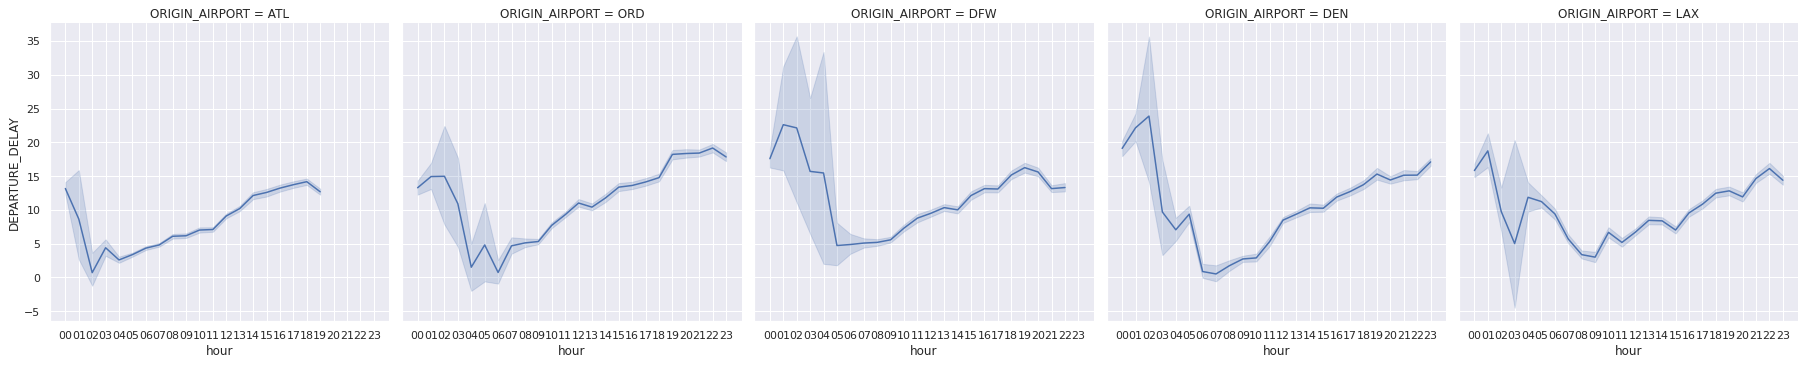

In [2]:
sql = """
SELECT *
FROM `ba780-team-1b.flights.delays` 
WHERE ORIGIN_AIRPORT IN ('ATL', 'ORD', 'DFW', 'DEN', 'LAX')
"""

snsplot = client.query(sql).to_dataframe()
snsplot['SCHEDULED_DEPARTURE'] = pd.to_datetime(snsplot['DATE'].astype(str) + ' ' + snsplot['SCHEDULED_ARRIVAL'].astype(str))
snsplot['hour'] = pd.to_datetime(snsplot['SCHEDULED_DEPARTURE']).dt.strftime('%H')
snsplot.sort_values(by='hour', inplace=True)

sns.set(rc={'figure.figsize':(10,8)})
sns.relplot(x='hour', y='DEPARTURE_DELAY', data=snsplot, col = 'ORIGIN_AIRPORT', col_order=['ATL', 'ORD', 'DFW', 'DEN', 'LAX'], kind='line', sort=True);

The plots show some interesting results. Contrary to what one might think, it appears that delay times are longer at night and peak around midnight. Even more interesting is that this trend is consistent for all 5 airports! Though there could be many reasons for this, one could be that domestic airlines need more maintenence after having flown multiple trips in the day. Another could be that the delay times from flights early on in the day affect later flights like a domino effect.

#### 2.) What does the relationship between flight distance and delay look like?

In the following plots, we examine at our top 5 busy airports what kind of relationship can be seen between the distance of a flight and the average departure + arrival delay. To reduce extreme spikes/variability in our plots, we set the delay time limit to 2 hours.

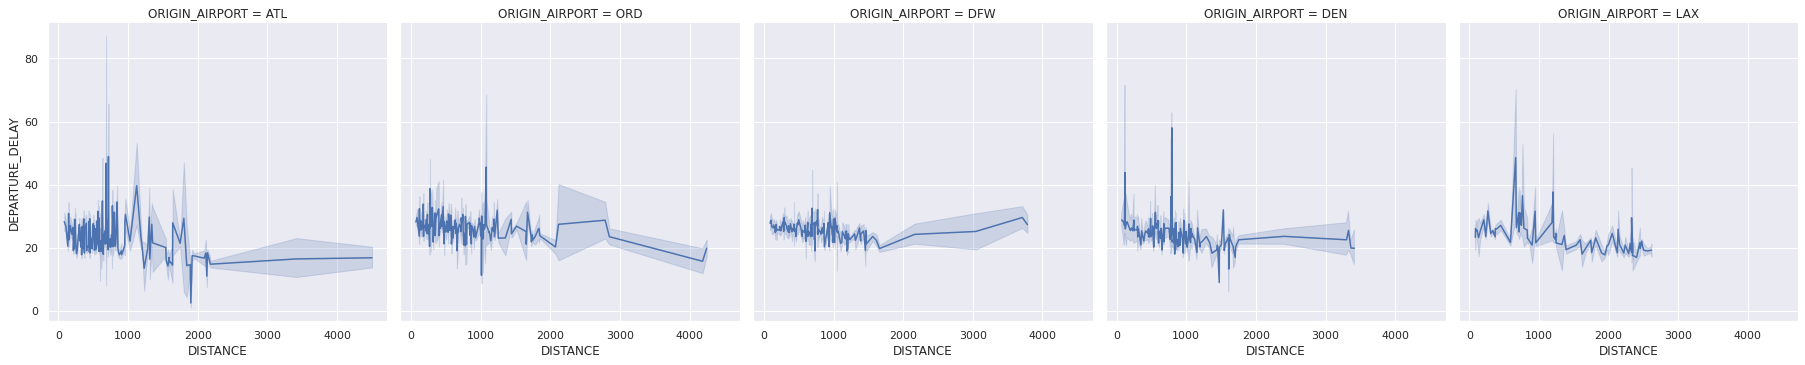

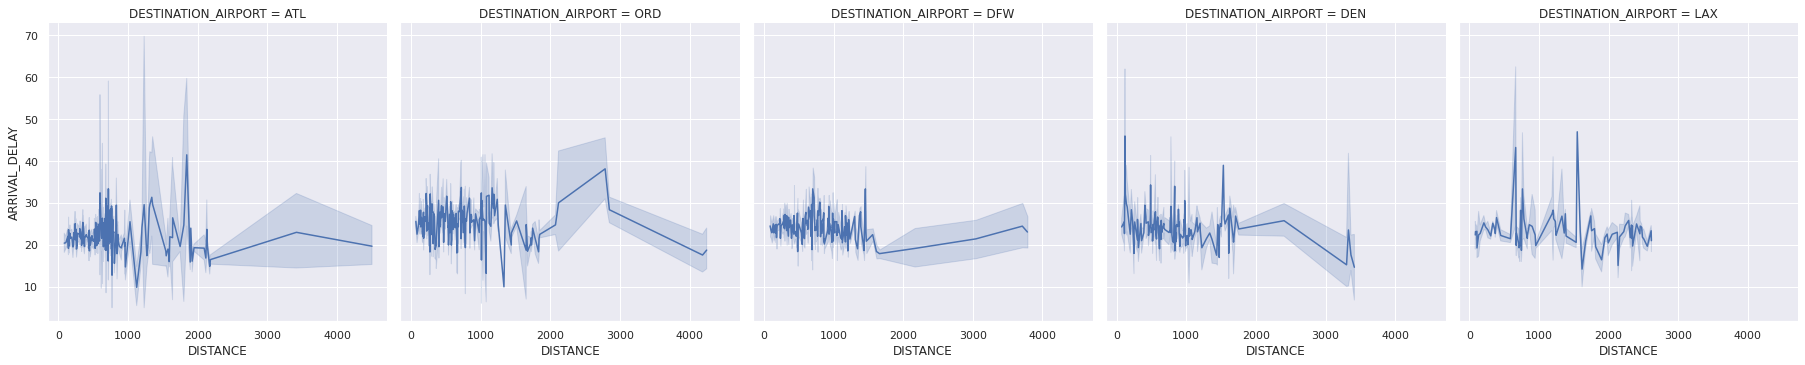

In [22]:
ori = """
SELECT * 
FROM `ba780-team-1b.flights.delays`
WHERE ORIGIN_AIRPORT IN ('ATL', 'ORD', 'DFW', 'DEN', 'LAX')
AND DEPARTURE_DELAY < 120 
AND DEPARTURE_DELAY > 0
"""
df_a = client.query(ori).to_dataframe()

dest = """
SELECT * 
FROM `ba780-team-1b.flights.delays`
WHERE DESTINATION_AIRPORT IN ('ATL', 'ORD', 'DFW', 'DEN', 'LAX')
AND ARRIVAL_DELAY < 120 
AND ARRIVAL_DELAY > 0
"""
df_d = client.query(dest).to_dataframe()

sns.set(rc={'figure.figsize':(10,8)})
sns.relplot(y='DEPARTURE_DELAY',x='DISTANCE',data=df_a,kind='line',col='ORIGIN_AIRPORT',col_order=['ATL', 'ORD', 'DFW', 'DEN', 'LAX'])
sns.relplot(y='ARRIVAL_DELAY',x='DISTANCE',data=df_d,kind='line',col='DESTINATION_AIRPORT',col_order=['ATL', 'ORD', 'DFW', 'DEN', 'LAX']);

It appears that the distance of a flight does not have a strong relationship with delay times. There is too much variability in flights under 2000 miles, and oddly enough there are many smooth/straight lines in flights above 2000 miles. This could be the result of not having enough samples in that range.

#### 3.) What about flight duration and delays?

There is a column in our dataset called "elapsed time", which is the entire flight duration + taxi times. We will use this variable instead of distance and see what the trends look like.

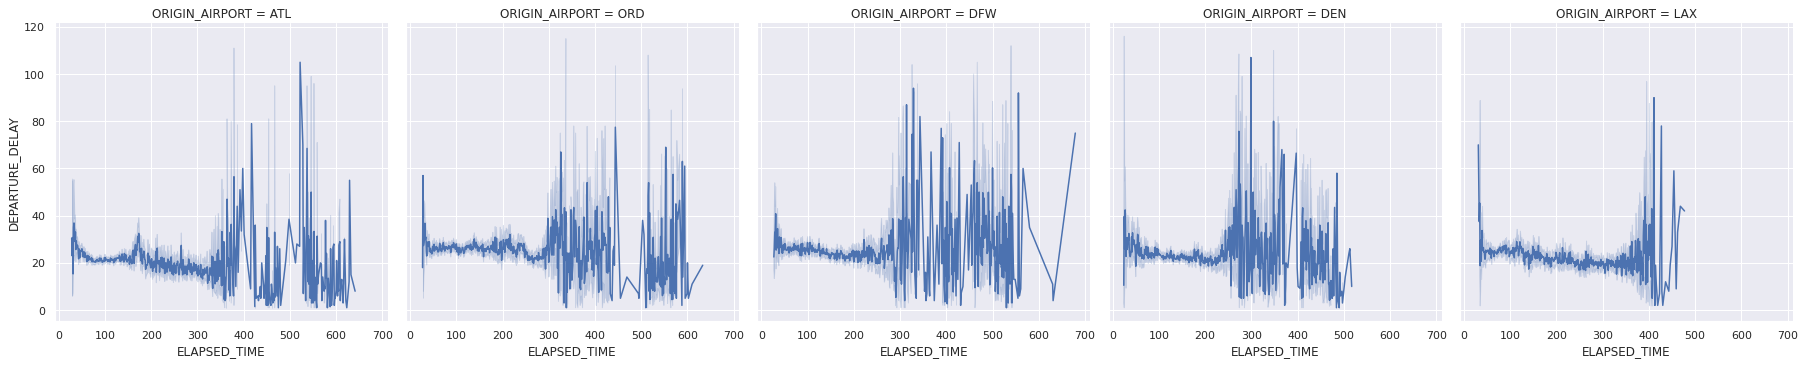

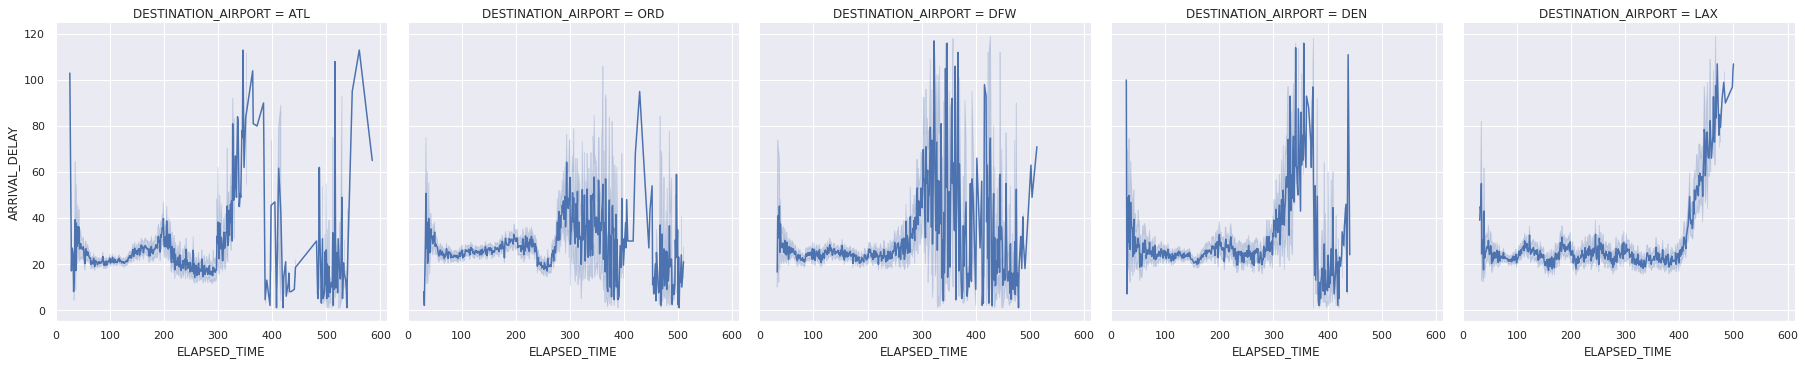

In [23]:
sns.set_style("darkgrid")
sns.relplot(y='DEPARTURE_DELAY',x='ELAPSED_TIME',data=df_a,kind='line',col='ORIGIN_AIRPORT',col_order=['ATL', 'ORD', 'DFW', 'DEN', 'LAX'])
sns.relplot(y='ARRIVAL_DELAY',x='ELAPSED_TIME',data=df_d,kind='line',col='DESTINATION_AIRPORT',col_order=['ATL', 'ORD', 'DFW', 'DEN', 'LAX']);

Contrary to what we saw in flight distance vs delays, this time we do see stronger trends. In both departure and arrival delays, flights with a duration of 50-300 minutes tend to be delayed by 20-30 minutes. After the 300 minute mark, the data begins to show a lot of variability and relationships cease to exist. LAX for arrival delays however, shows a strong trend. Past 400 minutes, as the flight duration gets longer, the arrival delay on average gets longer as well.

In conclusion, it appears that delay trends are not very strong when looking at individual airports and the flights that are operated there. We were able to, however find an hourly pattern of delay lengths at each airport.

## VII. Cancellations (By Airport)

- [x] I. A Glimpse at the Raw Data
- [x] II. Data Pre-Processing
- [x] III. Delays (By Airline)
- [x] IV. Cancellations (By Airline)
- [x] V. Identifying Busy Airports
- [x] VI. Delays (By Airport)
- [x] VII. Cancellations (By Airport)
- [ ] VIII. Taxiing (By Airport)
- [ ] IX. Correlation Heatmap
- [ ] X. Machine Learning

#### 1.) What are the top 5 airports that experienced the most number of cancellations?

First, let's look at which airports experienced the most number of cancellations in 2015.

In [99]:
cancel_data = """
SELECT *
FROM `ba780-team-1b.flights.cancellations`
WHERE DIVERTED = 0
"""
cancellations = client.query(cancel_data).to_dataframe()

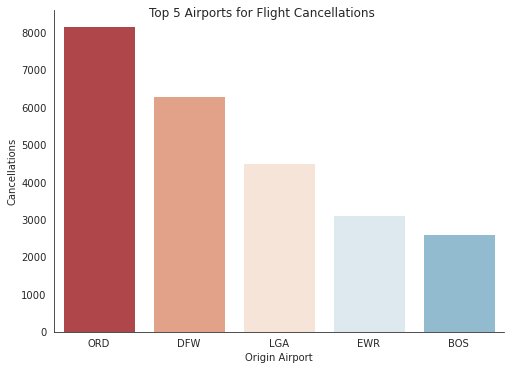

In [100]:
cancel_count = cancellations.groupby('ORIGIN_AIRPORT')['ORIGIN_AIRPORT'].count().sort_values(ascending=False).head(5)
top_5_cancellations = pd.DataFrame({'Count':cancel_count})

cancel_count_all = cancellations.groupby('ORIGIN_AIRPORT')['ORIGIN_AIRPORT'].count()
all_cancellations = pd.DataFrame({'Count':cancel_count_all})

sns.set_style("white")
sns.set_palette('RdBu')
g = sns.catplot(x='ORIGIN_AIRPORT', y='Count', data=top_5_cancellations.reset_index(), kind='bar', height=5, aspect=1.4)
g.set(xlabel='Origin Airport', ylabel='Cancellations')
g.fig.suptitle('Top 5 Airports for Flight Cancellations')
plt.show()

Looks like two of our Top 5 busiest airports (Chicaho O'Hare & Dallas Fortworth) made it into the top 2. The rest are LaGuardia, Newark, and Boston, respectively.

#### 2.) How many cancellations did our selected 5 airports have?

In [102]:
# Retrieve data from bigquery -- Cancellations in the top 5 busiest airports
top5 = """
SELECT * 
FROM `ba780-team-1b.flights.cancellations`
WHERE DIVERTED = 0
AND ORIGIN_AIRPORT IN ('ATL', 'ORD', 'DFW', 'DEN', 'LAX')
"""
canc_top5 = client.query(top5).to_dataframe()

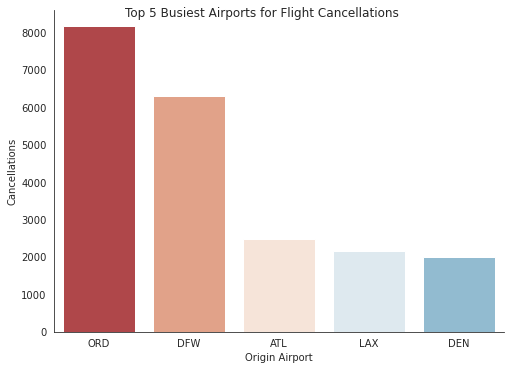

In [104]:
# Calculate cancellations by each airport
canc_top5_count = canc_top5.groupby('ORIGIN_AIRPORT')['ORIGIN_AIRPORT'].count().sort_values(ascending=False)
canc_top5_count = pd.DataFrame({'Count':canc_top5_count}).reset_index()

# Plotting 
sns.set_style('white')
sns.set_palette('RdBu')
g = sns.catplot(x='ORIGIN_AIRPORT', y='Count', data=canc_top5_count, kind='bar', height=5, aspect=1.4)
g.set(xlabel='Origin Airport', ylabel='Cancellations')
g.fig.suptitle('Top 5 Busiest Airports for Flight Cancellations')
plt.show()

Based off of these results, we can conclude there is a bit of a pattern here with busy airports having more cancellations. 

#### 3.) What did cancellations look like per month at our top 5 busy airports?

Let's breakdown the cancellations for each month for the top 5 busiest airports.

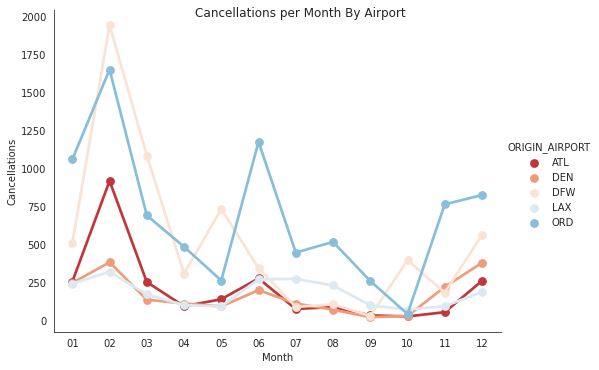

In [105]:
# Calculate cancellations per month by each airport
canc_top5['Month'] = pd.to_datetime(canc_top5['DATE']).dt.strftime('%m')
canc_mon_count = canc_top5.groupby(['ORIGIN_AIRPORT', 'Month'], as_index=False)['FLIGHT_NUMBER'].count()
canc_mon_count = canc_mon_count.rename(columns={"FLIGHT_NUMBER": "Cancellations"})

# Plotting
sns.set_style('white')
g = sns.catplot(x='Month', y='Cancellations', hue='ORIGIN_AIRPORT', data=canc_mon_count, kind='point', height=5, aspect=1.4)
g.set(xlabel='Month', ylabel='Cancellations')
g.fig.suptitle('Cancellations per Month By Airport')
plt.show()

Based on the graph, each of the top 5 busiest airports shows a significant increase in February's cancellations. The flights from July to October operate with the lowest and the most stable cancellations during the whole year.

#### 4.) What was the main factor for these cancellations?

To examine the main reason for these canceled flights, let's focus on the cancellations caused by weather factors for the top 5 airports. 

In [106]:
# Retrieve data from bigquery -- Cancellations due to weather in the top 5 busiest airports
canc_weather = """
SELECT * 
FROM `ba780-team-1b.flights.cancellations`
WHERE DIVERTED = 0
AND CANCELLATION_REASON = 'B'
AND ORIGIN_AIRPORT IN ('ATL', 'ORD', 'DFW', 'DEN', 'LAX')
"""
canc_weather = client.query(canc_weather).to_dataframe()

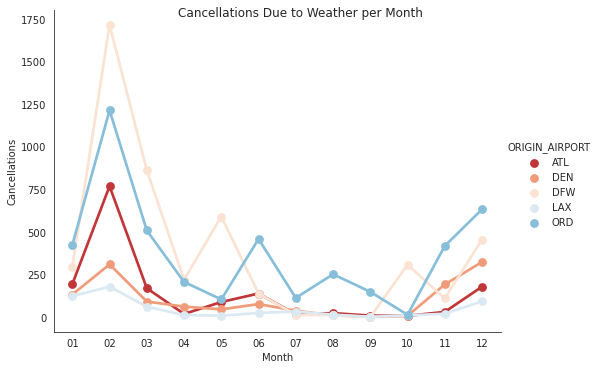

In [107]:
# Calculate flights cancelled due to weather per month by each airport
canc_weather['Month'] = pd.to_datetime(canc_weather['DATE']).dt.strftime('%m')
canc_weather_count = canc_weather.groupby(['ORIGIN_AIRPORT', 'Month'], as_index=False)['FLIGHT_NUMBER'].count()
canc_weather_count = canc_weather_count.rename(columns={"FLIGHT_NUMBER": "Cancellations"})

# Plotting
sns.set_style('white')
g = sns.catplot(x='Month', y='Cancellations', hue='ORIGIN_AIRPORT', data=canc_weather_count, kind='point', height=5, aspect=1.4)
g.set(xlabel='Month', ylabel='Cancellations')
g.fig.suptitle('Cancellations Due to Weather per Month')
plt.show()

According to the original data, the weather factors account for the main proportion of cancellations. We can observe that each airport's line trend is generally consistent with which shown in the above graph. Namely, the results support the presumption. However, the gap between the cancellations due to weather factors and the total cancellations may mainly be caused by air carriers, as discussed in the previous part (part IV).

## VIII. Taxiing (By Airport)

- [x] I. A Glimpse at the Raw Data
- [x] II. Data Pre-Processing
- [x] III. Delays (By Airline)
- [x] IV. Cancellations (By Airline)
- [x] V. Identifying Busy Airports
- [x] VI. Delays (By Airport)
- [x] VII. Cancellations (By Airport)
- [x] VIII. Taxiing (By Airport)
- [ ] IX. Correlation Heatmap
- [ ] X. Machine Learning

Though not necessarily connected with delay times, the duration of a plane taxiing to and off the runway is still time spent waiting for your flight to finally take off! Congestion, airport size, and number of runways could all play a role in determining how long it will take you to leave your gate and take flight.

#### 1.) What do average taxi times look like by the hour?

Here, we will be examining the average taxiing times by the hour. Two subplots will be created: one for origin airport and one for destination airport. Our goal here is to get a high level overview of the average taxi time one would experience at the top 5 busiest airports.

In [53]:
#Query origin airport data
ori = """
SELECT *
FROM `ba780-team-1b.flights.delays` 
WHERE ORIGIN_AIRPORT IN ('ATL', 'ORD', 'DFW', 'DEN', 'LAX')
"""

#Query destination airport data
dest = """
SELECT *
FROM `ba780-team-1b.flights.delays` 
WHERE DESTINATION_AIRPORT IN ('ATL', 'ORD', 'DFW', 'DEN', 'LAX')
"""

#Filter departure time for hour and sort by hour
ori_plot = client.query(ori).to_dataframe()
ori_plot['SCHEDULED_DEPARTURE'] = pd.to_datetime(ori_plot['DATE'].astype(str) + ' ' + ori_plot['SCHEDULED_DEPARTURE'].astype(str))
ori_plot['hour'] = pd.to_datetime(ori_plot['SCHEDULED_DEPARTURE']).dt.strftime('%H')
ori_plot.sort_values(by='hour', inplace=True)

#Filter arrival time for hour and sort by hour
dest_plot = client.query(dest).to_dataframe()
dest_plot['SCHEDULED_ARRIVAL'] = pd.to_datetime(dest_plot['DATE'].astype(str) + ' ' + dest_plot['SCHEDULED_ARRIVAL'].astype(str))
dest_plot['hour'] = pd.to_datetime(dest_plot['SCHEDULED_ARRIVAL']).dt.strftime('%H')
dest_plot.sort_values(by='hour', inplace=True)

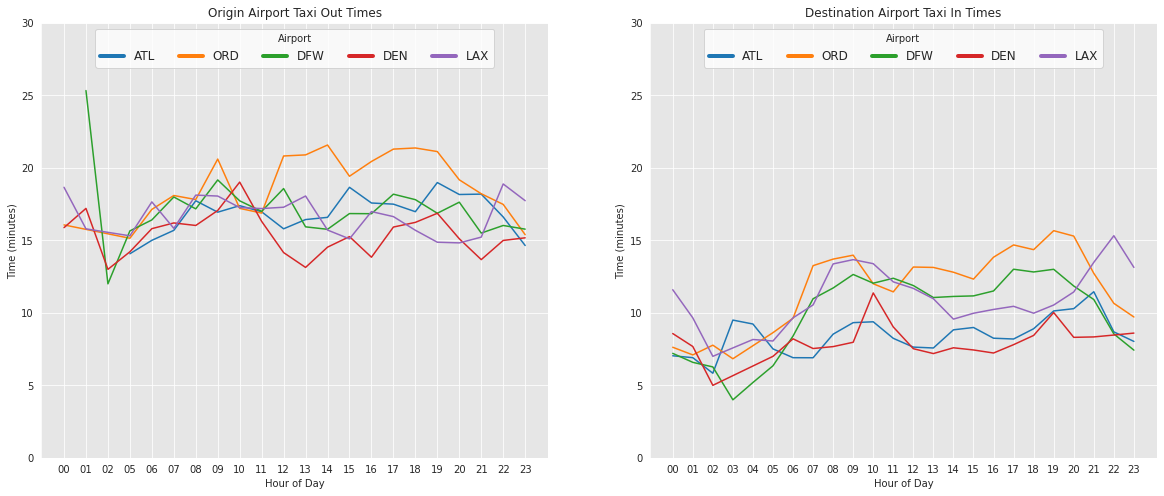

In [54]:
# Plot
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.lineplot(x='hour', y='TAXI_OUT', data=ori_plot, hue = 'ORIGIN_AIRPORT', hue_order=['ATL','ORD','DFW','DEN','LAX'], ci=None, sort=True, ax=ax[0])
sns.lineplot(x='hour', y='TAXI_IN', data=dest_plot, hue = 'DESTINATION_AIRPORT', hue_order=['ATL','ORD','DFW','DEN','LAX'], ci=None, sort=True, ax=ax[1])
ax[0].set_ylim(0, 30)
ax[0].set_title('Origin Airport Taxi Out Times')
ax[0].set_xlabel('Hour of Day')
ax[0].set_ylabel('Time (minutes)')
for line in ax[0].legend(facecolor='white', ncol=5, title='Airport', loc='upper center', fontsize='large').get_lines():
    line.set_linewidth(4.0)
ax[1].set_ylim(0, 30)
ax[1].set_title('Destination Airport Taxi In Times')
ax[1].set_xlabel('Hour of Day')
ax[1].set_ylabel('Time (minutes)')
for line in ax[1].legend(facecolor='white', ncol=5, title='Airport', loc='upper center', fontsize='large').get_lines():
    line.set_linewidth(4.0);

As evident in the graphs, all the airports' taxi times tend to hover around similar ranges throughout the day. There are a few hours in the day that show Chicago O'Hare Airport as having the longest average taxi times and Denver International Airport having the lowest average taxi times. We also see a bit of a trend where taxi times rise slightly throughout the day and dip back down after midnight.

#### 2.) What did average taxi times look like all throughout 2015?

To follow up on the previous analysis, we will now explore average taxi times throughout the year (categorized by month). However, we would like to do more than just view our top 5 busiest airports. Common knowledge would suggest these airports are also geographically large, so the factor of runway to gate distance might play a bigger role than runway traffic. To account for this, we will also include 5 addtional geographically large airports for comparison. 

| Top 5 Busiest Airport                                  | Size (acres) | Geographically Large Airport                 | Size (acres)|
|--------------------------------------------------------|--------------|----------------------------------------------|-------------|
| ATL (Hartsfield-Jackson Atlanta International Airport) | 4700         | IAD (Washington Dulles International Airport)| 13000       |
| ORD (Chicago O'Hare International Airport)             | 7200         | MCO (Orlando International Airport)          | 11609       |
| DFW (Dallas/Fort Worth International Airport)          | 18076        | IAH (George Bush Intercontinental)           | 10000       |
| DEN (Denver International Airport)                     | 33531        | SLC (Salt Lake City International Airport)   | 7200        |
| LAX (Los Angeles International Airport)                | 2950         | SFO (San Francisco International Airport)    | 5207        |

In [24]:
origin_count = delays.groupby('ORIGIN_AIRPORT')['ORIGIN_AIRPORT'].count()
destination_count = delays.groupby('DESTINATION_AIRPORT')['DESTINATION_AIRPORT'].count()
count = pd.DataFrame({'origin': origin_count, 'destination': destination_count})
count['total'] = count['origin'] + count['destination']
count.sort_values(by=['total'], ascending=False, inplace = True)
x = count.iloc[:5, :]

origin_count = delays.groupby('ORIGIN_AIRPORT')['ORIGIN_AIRPORT'].count()
destination_count = delays.groupby('DESTINATION_AIRPORT')['DESTINATION_AIRPORT'].count()
count2 = pd.DataFrame({'origin': origin_count, 'destination': destination_count})
count2['total'] = count2['origin'] + count2['destination']
y = count2.loc[['IAD', 'MCO', 'IAH', 'SLC', 'SFO']]

display('x', 'y')

,origin,destination,total
ATL,376720,376710,753430
ORD,304737,304058,608795
DFW,253797,253350,507147
DEN,211926,211726,423652
LAX,210047,210074,420121
,origin,destination,total
IAD,36725,36744,73469
MCO,118815,118913,237728
IAH,157492,157316,314808
SLC,105470,105425,210895


The above tables give us a side by side comparison of how busy these airports are.

In [69]:
# Query origin airport data
ori = """
SELECT *
FROM `ba780-team-1b.flights.delays` 
WHERE ORIGIN_AIRPORT IN ('ATL', 'ORD', 'DFW', 'DEN', 'LAX', 'IAD', 'MCO', 'IAH', 'SLC', 'SFO')
"""

# Query destination airport data
dest = """
SELECT *
FROM `ba780-team-1b.flights.delays` 
WHERE DESTINATION_AIRPORT IN ('ATL', 'ORD', 'DFW', 'DEN', 'LAX', 'IAD', 'MCO', 'IAH', 'SLC', 'SFO')
"""

#Filter departure time for week and sort by week
ori_plot = client.query(ori).to_dataframe()
ori_plot['SCHEDULED_DEPARTURE'] = pd.to_datetime(ori_plot['DATE'].astype(str) + ' ' + ori_plot['SCHEDULED_DEPARTURE'].astype(str))
ori_plot['month'] = pd.to_datetime(ori_plot['SCHEDULED_DEPARTURE']).dt.strftime('%m')
ori_plot.sort_values(by='month', inplace=True)

#Filter arrival time for week and sort by week
dest_plot = client.query(dest).to_dataframe()
dest_plot['SCHEDULED_ARRIVAL'] = pd.to_datetime(dest_plot['DATE'].astype(str) + ' ' + dest_plot['SCHEDULED_ARRIVAL'].astype(str))
dest_plot['month'] = pd.to_datetime(dest_plot['SCHEDULED_ARRIVAL']).dt.strftime('%m')
dest_plot.sort_values(by='month', inplace=True)

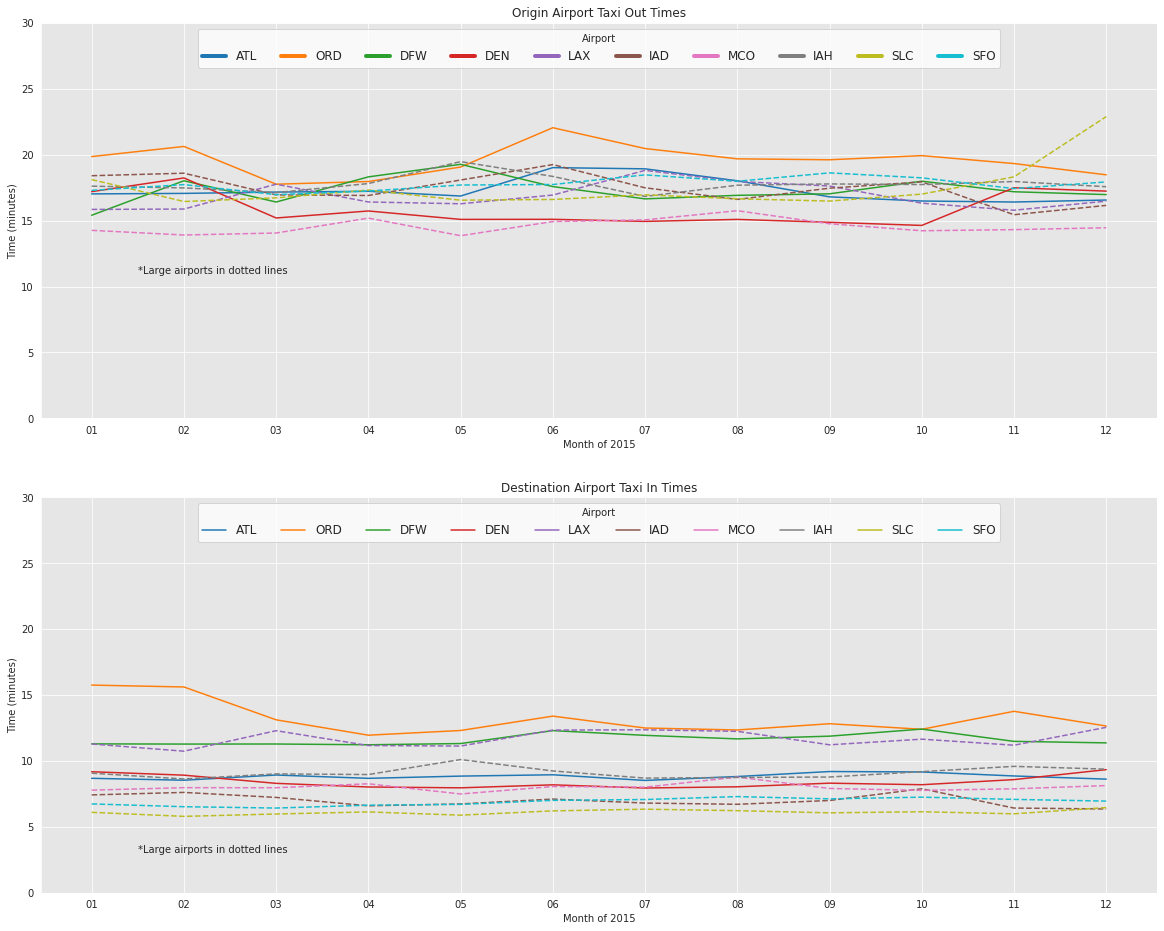

In [73]:
# Plot
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
fig, ax = plt.subplots(2,1, figsize=(20,16))
sns.lineplot(x='month', y='TAXI_OUT', data=ori_plot, hue = 'ORIGIN_AIRPORT', hue_order=['ATL', 'ORD', 'DFW', 'DEN', 'LAX', 'IAD', 'MCO', 'IAH', 'SLC', 'SFO'], ci=None, sort=True, ax=ax[0])
sns.lineplot(x='month', y='TAXI_IN', data=dest_plot, hue = 'DESTINATION_AIRPORT', hue_order=['ATL', 'ORD', 'DFW', 'DEN', 'LAX', 'IAD', 'MCO', 'IAH', 'SLC', 'SFO'], ci=None, sort=True, ax=ax[1])
ax[0].set_ylim(0, 30)
for i in range(4,10):
    ax[0].lines[i].set_linestyle('--')
ax[0].set_title('Origin Airport Taxi Out Times')
ax[0].set_xlabel('Month of 2015')
ax[0].set_ylabel('Time (minutes)')
ax[0].text(0.5, 11, '*Large airports in dotted lines', size=10)
for line in ax[0].legend(facecolor='white', ncol=10, title='Airport', loc='upper center', fontsize='large').get_lines():
    line.set_linewidth(4.0)
ax[1].set_ylim(0, 30)
for i in range(4,10):
    ax[1].lines[i].set_linestyle('--')
ax[1].set_title('Destination Airport Taxi In Times')
ax[1].set_xlabel('Month of 2015')
ax[1].set_ylabel('Time (minutes)')
ax[1].legend(facecolor='white', ncol=10, title='Airport', loc='upper center', fontsize='large')
ax[1].text(0.5, 3, '*Large airports in dotted lines', size=10);

When it comes to both origin and destination airports, the average taxi times tend to lump together within a 5-10 minute range. Thus, we can conclude that congestion caused by high volume of flights may not necessarily be the main factor of long taxi times. It's very possible that airport size plays a role too.

## IX. Correlation Heatmap

- [x] I. A Glimpse at the Raw Data
- [x] II. Data Pre-Processing
- [x] III. Delays (By Airline)
- [x] IV. Cancellations (By Airline)
- [x] V. Identifying Busy Airports
- [x] VI. Delays (By Airport)
- [x] VII. Cancellations (By Airport)
- [x] VIII. Taxiing (By Airport)
- [x] IX. Correlation Heatmap
- [ ] X. Machine Learning

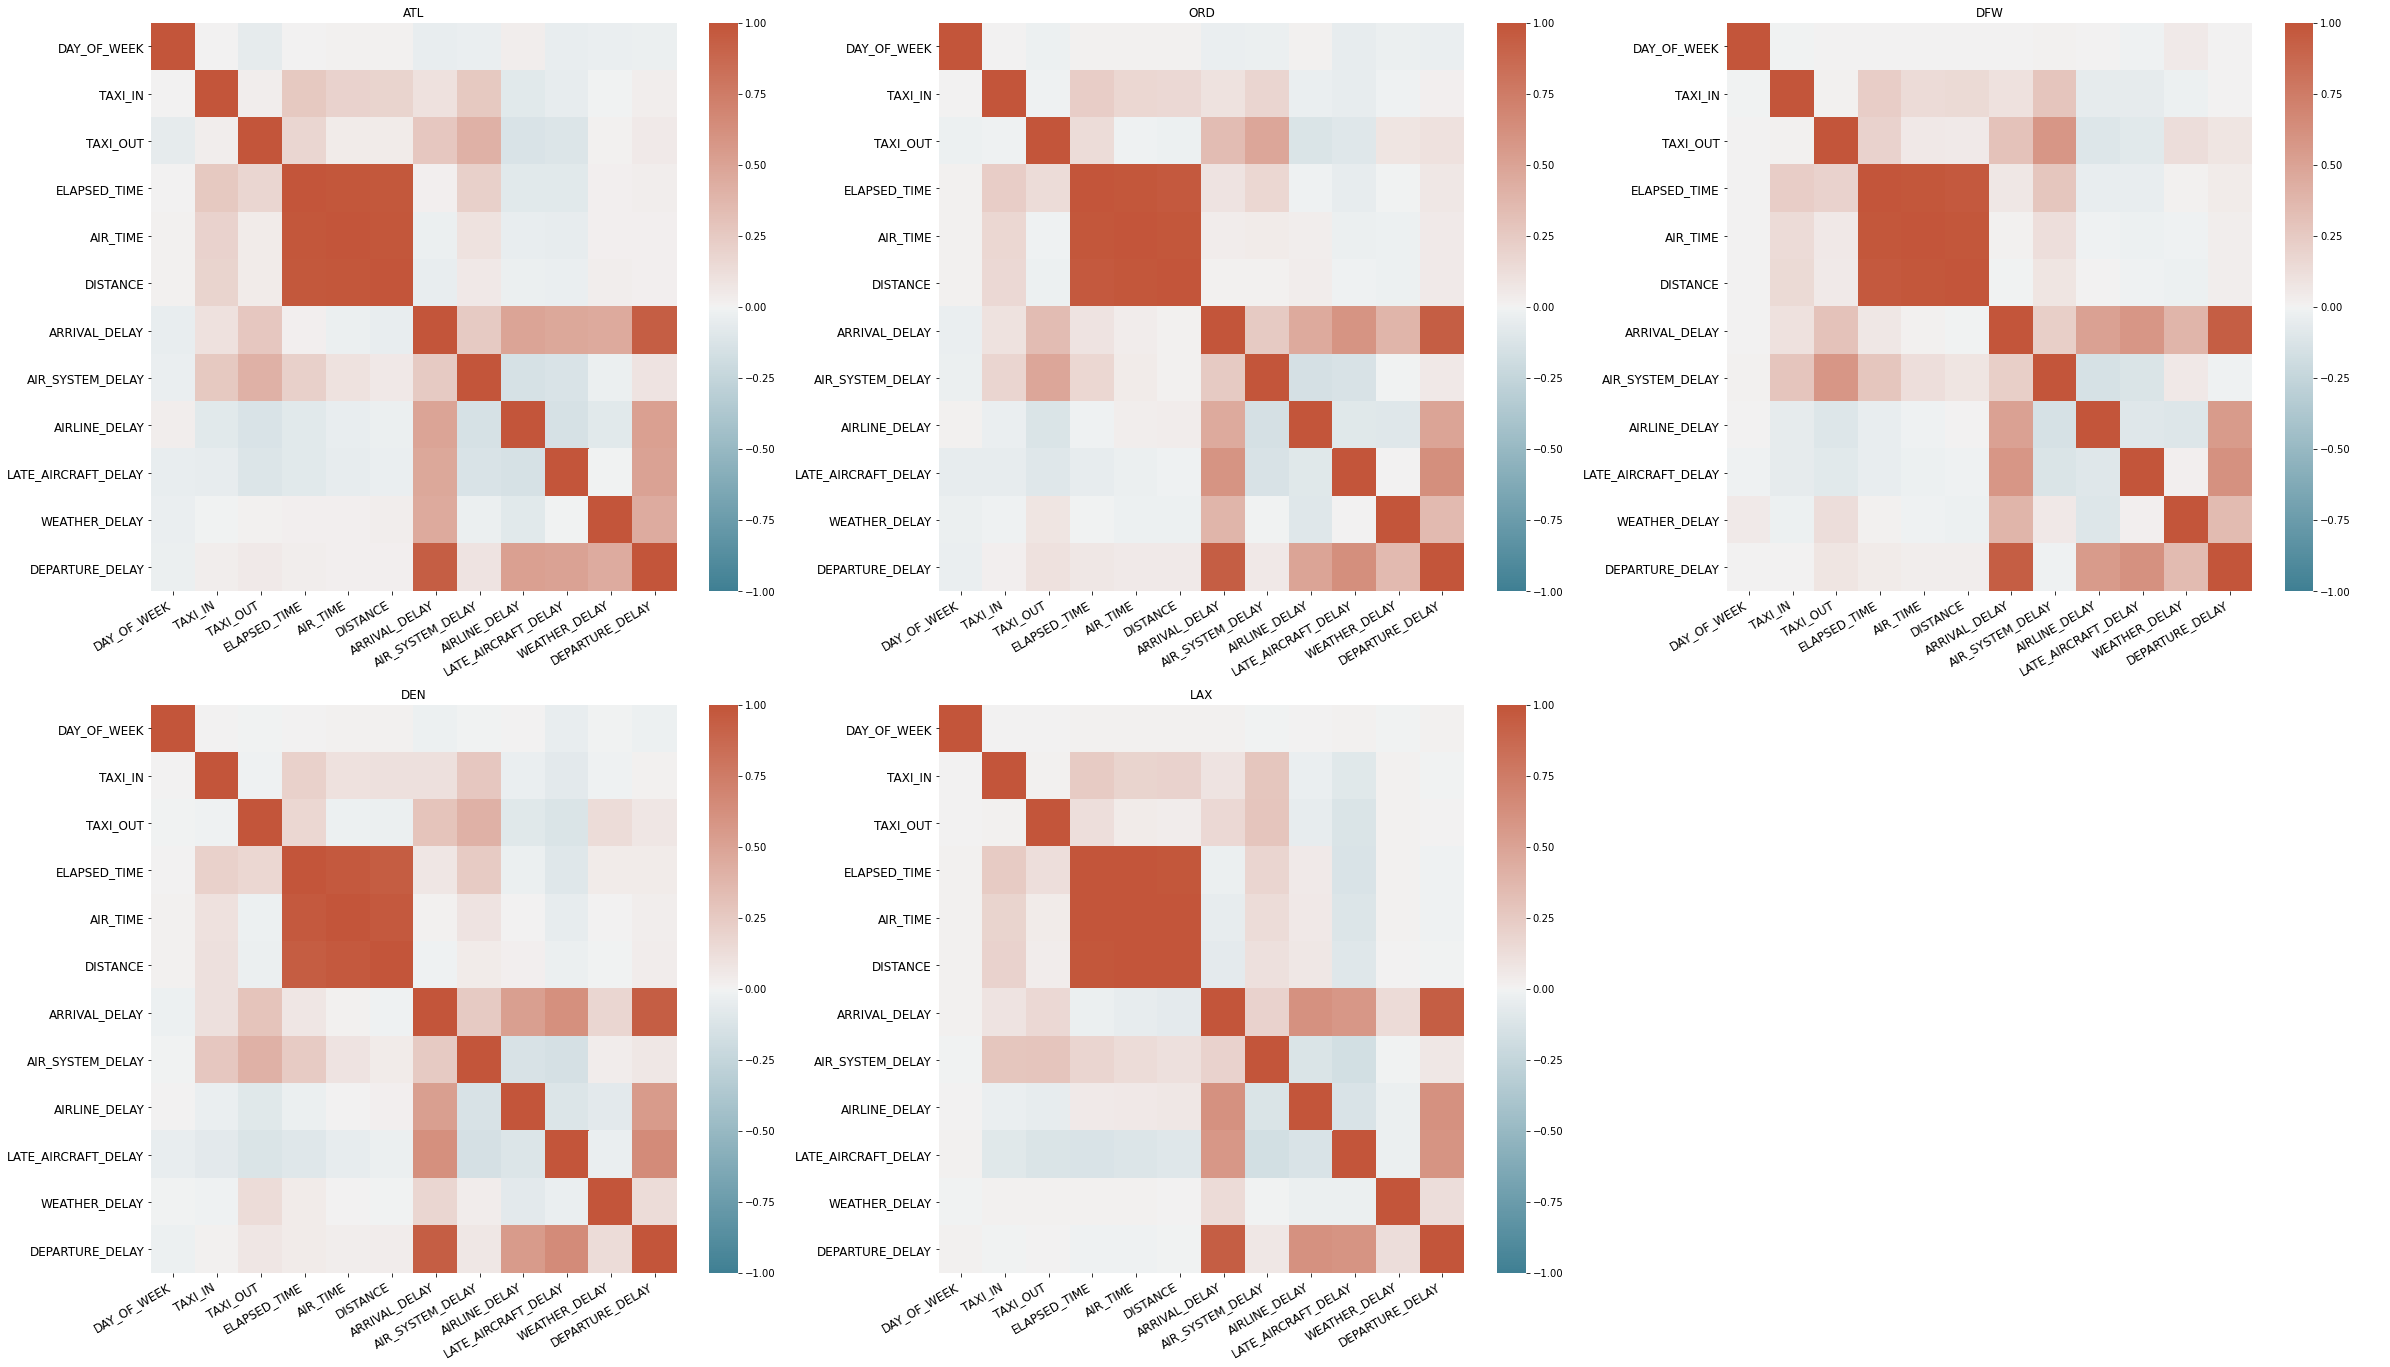

In [8]:
sql_corr_data = """
SELECT 
ORIGIN_AIRPORT, DAY_OF_WEEK, TAXI_IN, TAXI_OUT, ELAPSED_TIME, AIR_TIME, DISTANCE, ARRIVAL_DELAY, AIR_SYSTEM_DELAY, AIRLINE_DELAY, LATE_AIRCRAFT_DELAY, WEATHER_DELAY, DEPARTURE_DELAY
FROM `ba780-team-1b.flights.delays` 
"""
corr_data = client.query(sql_corr_data).to_dataframe()
corr_ATL = corr_data[corr_data['ORIGIN_AIRPORT'] == 'ATL'].corr()
corr_ORD = corr_data[corr_data['ORIGIN_AIRPORT'] == 'ORD'].corr()
corr_DFW = corr_data[corr_data['ORIGIN_AIRPORT'] == 'DFW'].corr()
corr_DEN = corr_data[corr_data['ORIGIN_AIRPORT'] == 'DEN'].corr()
corr_LAX = corr_data[corr_data['ORIGIN_AIRPORT'] == 'LAX'].corr()


fig, ax = plt.subplots(2,3, figsize=(40,23))
sns.heatmap(data=corr_ATL, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(220, 20, as_cmap=True), ax=ax[0,0])
sns.heatmap(data=corr_ORD, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(220, 20, as_cmap=True), ax=ax[0,1])
sns.heatmap(data=corr_DFW, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(220, 20, as_cmap=True), ax=ax[0,2])
sns.heatmap(data=corr_DEN, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(220, 20, as_cmap=True), ax=ax[1,0])
sns.heatmap(data=corr_LAX, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(220, 20, as_cmap=True), ax=ax[1,1])
ax[0,0].set_xticklabels(ax[0,0].get_xticklabels(), horizontalalignment='right', rotation=30, fontsize=12)
ax[0,1].set_xticklabels(ax[0,1].get_xticklabels(), horizontalalignment='right', rotation=30, fontsize=12)
ax[0,2].set_xticklabels(ax[0,2].get_xticklabels(), horizontalalignment='right', rotation=30, fontsize=12)
ax[1,0].set_xticklabels(ax[1,0].get_xticklabels(), horizontalalignment='right', rotation=30, fontsize=12)
ax[1,1].set_xticklabels(ax[1,1].get_xticklabels(), horizontalalignment='right', rotation=30, fontsize=12)
ax[0,0].set_yticklabels(ax[0,0].get_xticklabels(), horizontalalignment='right', fontsize=12)
ax[0,1].set_yticklabels(ax[0,1].get_xticklabels(), horizontalalignment='right', fontsize=12)
ax[0,2].set_yticklabels(ax[0,2].get_xticklabels(), horizontalalignment='right', fontsize=12)
ax[1,0].set_yticklabels(ax[1,0].get_xticklabels(), horizontalalignment='right', fontsize=12)
ax[1,1].set_yticklabels(ax[1,1].get_xticklabels(), horizontalalignment='right', fontsize=12)
ax[1,2].axis('off')
ax[0,0].set_title('ATL', fontsize=12)
ax[0,1].set_title('ORD')
ax[0,2].set_title('DFW')
ax[1,0].set_title('DEN')
ax[1,1].set_title('LAX');

For all 5 busy airports, we included a correlation heat map to see which variables had strong correlations with one another. Across all 5, we see the strongest correlations when it comes to delays and the delay types, as expected. As the saying goes: correlation does not equal causation. For example, day of the week has a slight negative correlation with late aircraft delay for Denver Airport. It begs the question: is the day of the week really the reason why an airline's plane was running late? Probably not. There are many other factors as well, but sometimes it is helpful to see correlations to get a better understanding of the dataset while in the exploring stages.

# X. Machine Learning 

- [x] I. A Glimpse at the Raw Data
- [x] II. Data Pre-Processing
- [x] III. Delays (By Airline)
- [x] IV. Cancellations (By Airline)
- [x] V. Identifying Busy Airports
- [x] VI. Delays (By Airport)
- [x] VII. Cancellations (By Airport)
- [x] VIII. Taxiing (By Airport)
- [x] IX. Correlation Heatmap
- [x] X. Machine Learning

In the final section of our notebook, we want to try to fit a machine learning model on our data. In our last project, we used linear regression to predict delay times. This time we will be incorporating a weather dataset to see if we can predict if a delay will occur or not. <br />

The weather dataset is also from kaggle: https://www.kaggle.com/selfishgene/historical-hourly-weather-data?select=pressure.csv 

#### 1.) Atlanta Airport: Predict all departure delays based on weather?

For this model, we will only be focusing on our busiest airport: Atlanta.

In [14]:
atlanta = """
SELECT * 
FROM `ba780-team-1b.flights.atlanta_weather` 
"""
atlanta_weather = client.query(atlanta).to_dataframe()
atlanta_weather.head(3)

,datetime,humidity,pressure,temperature,weather_description,wind_speed
0,2015-09-16 08:00:00+00:00,77.0,1026.0,288.720000,few clouds,0.0
1,2015-06-03 01:00:00+00:00,69.0,1027.0,295.724667,light rain,0.0
2,2015-06-03 02:00:00+00:00,79.0,1027.0,294.046333,light rain,0.0


In [6]:
# Remove timezone offset on datetime column
atlanta_weather['datetime']= atlanta_weather['datetime'].dt.strftime('%Y-%m-%d %H:%M:%S')
atlanta_weather['datetime'] = pd.to_datetime(atlanta_weather['datetime'].astype(str))

# Prep delays dataframe for merging
delays['SCHEDULED_DEPARTURE'] = pd.to_datetime(delays['DATE'].astype(str) + ' ' + delays['SCHEDULED_DEPARTURE'].astype(str))
delays_update = delays[delays['ORIGIN_AIRPORT'] == 'ATL']
delays_update = delays_update.assign(SCHEDULED_DEPARTURE=delays_update.SCHEDULED_DEPARTURE.dt.round('H')).reset_index()
delays_update = delays_update.drop('index', axis=1)

# Merge delays and Atlanta weather dataframes
delays_update = delays_update.merge(atlanta_weather, left_on='SCHEDULED_DEPARTURE', right_on='datetime')

For the target variable, we needed to set a standard. As of now, our departure delays have zeroes, negative and positive numbers. According to the FAA, a flight is considered delayed if the wait goes over 15 minutes. With this in mind, we will set all values less than 15 equal to 0 and all values greater than or equal to 15 minutes to 1. 

In [ ]:
# Manual one hot encoding
ML_prep = delays_update[['DEPARTURE_DELAY', 'DAY_OF_WEEK', 'AIRLINE', 'DESTINATION_AIRPORT', 'DISTANCE', 'humidity', 'pressure', 'temperature', 'weather_description', 'wind_speed']]
ML_prep.loc[ML_prep['DEPARTURE_DELAY'] < 15, 'DEPARTURE_DELAY'] = 0
ML_prep.loc[ML_prep['DEPARTURE_DELAY'] >= 15, 'DEPARTURE_DELAY'] = 1

In [8]:
# Dropping irrelevant variables
departure_delay_df = ML_prep.drop(['DISTANCE', 'DESTINATION_AIRPORT'], axis=1) 

# One hot encoding
df_dummified = pd.get_dummies(departure_delay_df, drop_first=False) 

# Setting target variable to Departure Delay
X_df = df_dummified.drop('DEPARTURE_DELAY', axis = 1)
y_df = df_dummified.DEPARTURE_DELAY

# Split data into training and test sets
Xtrain, Xtest, ytrain, ytest = train_test_split(X_df, y_df, test_size=0.3, random_state=855, stratify = y_df)

# Run logistic regression model
model = LogisticRegression(max_iter=2000)
model.fit(Xtrain, ytrain)

# Predict test set
y_model = model.predict(Xtest)

# Test accuracy, sensitivity, and specificity
print("Our model is", round(sum(ytest == y_model)/len(y_model),4), "accurate!")
P = sum(ytest==1)
TP = sum((ytest == 1.0) & (y_model == 1.0))
print('True positive rate: ' + str(TP/P))
N = sum(ytest == 0)
TN = sum((ytest == 0) & (y_model == 0))
print('True negative rate: ' + str(TN/N))

Our model is 0.8269 accurate!
True positive rate: 0.0055268410009723145
True negative rate: 0.9990239926209552


The accuracy rate comes out to an impressive 0.8269! But before we jump to conclusions, we need to look at our true positive rate and true negative rate. Our model predicted almost all of the negative values and very little positive values, which means it is not such a good model after all. The reason why the accuracy is so high is primarily because the majority of flights in this dataframe aren't considered delayed by our standards.

Before we get discouraged, let's try a few other classification methods:

In [10]:
# Naive Bayes
model1 = GaussianNB()
model1.fit(Xtrain, ytrain)
y_model1 = model1.predict(Xtest)
print("Our model is", round(sum(ytest == y_model1)/len(y_model1),4), "accurate!")
P = sum(ytest==1)
TP = sum((ytest == 1.0) & (y_model1 == 1.0))
print('True positive rate: ' + str(TP/P))
N = sum(ytest == 0)
TN = sum((ytest == 0) & (y_model1 == 0))
print('True negative rate: ' + str(TN/N))

Our model is 0.7987 accurate!
True positive rate: 0.14441430837725808
True negative rate: 0.9357872947435031


In [12]:
#KNeighbors
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(Xtrain, ytrain)
y_model2 = knn.predict(Xtest)
print("Our model is", round(sum(ytest == y_model2)/len(y_model2),4), "accurate!")
P = sum(ytest==1)
TP = sum((ytest == 1.0) & (y_model2 == 1.0))
print('True positive rate: ' + str(TP/P))
N = sum(ytest == 0)
TN = sum((ytest == 0) & (y_model2 == 0))
print('True negative rate: ' + str(TN/N))

Our model is 0.8406 accurate!
True positive rate: 0.24768435596950003
True negative rate: 0.9648744597102009


By using different classification estimators, we were able to get the true positive rate up to double digit rates! <br />

We should keep in mind that in this model, our target variable was departure delays. Essentially, we had tried to generalize all delays as being influenced by weather, which is not the case. <br />

#### 2.) Atlanta Airport: Predict weather only delays?

To address the problem we recently brought up, we will switch the target variable over to weather delays and see if we can build a model that accurately predicts delays specifically caused by weather.

In [ ]:
# Choosing variables for ML dataframe
ML_prep = delays_update[['WEATHER_DELAY', 'DAY_OF_WEEK', 'AIRLINE', 'DESTINATION_AIRPORT', 'DISTANCE', 'humidity', 'pressure', 'temperature', 'weather_description', 'wind_speed']]

# Manually one hot encoding target variable
ML_prep.loc[ML_prep['WEATHER_DELAY'].isnull(), 'WEATHER_DELAY'] = 0
ML_prep.loc[ML_prep['WEATHER_DELAY'] < 15, 'WEATHER_DELAY'] = 0
ML_prep.loc[ML_prep['WEATHER_DELAY'] >= 15, 'WEATHER_DELAY'] = 1
ML_prep.head()

In [21]:
# Dropping irrelevant variables
weather_delay_df = ML_prep.drop(['DISTANCE', 'DESTINATION_AIRPORT'], axis=1) 

# One hot encoding
df_dummified = pd.get_dummies(weather_delay_df, drop_first=False) 

# Setting target variable to Departure Delay
X_df = df_dummified.drop('WEATHER_DELAY', axis = 1)
y_df = df_dummified.WEATHER_DELAY

# Split data into training and test sets
Xtrain, Xtest, ytrain, ytest = train_test_split(X_df, y_df, test_size=0.3, random_state=855, stratify = y_df)

# Run model
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(Xtrain, ytrain)

# Predict test set
y_model2 = knn.predict(Xtest)

# Test accuracy, sensitivity, and specificity
print("Our model is", round(sum(ytest == y_model2)/len(y_model2),4), "accurate!")
P = sum(ytest==1)
TP = sum((ytest == 1.0) & (y_model2 == 1.0))
print('True positive rate: ' + str(TP/P))
N = sum(ytest == 0)
TN = sum((ytest == 0) & (y_model2 == 0))
print('True negative rate: ' + str(TN/N))

Our model is 0.989 accurate!
True positive rate: 0.3621337340345605
True negative rate: 0.9964916058754385


As one would expect, we get even more promising results than when we were trying to predict all types of delays. 

#### 3.) Chicago Airport: Predict weather only delays?

Before concluding the ML section, we will try one more city: Chicago. Our target variable will be weather delay and we will use KNeighbors as our estimator.

In [3]:
chicago = """
SELECT *
FROM `ba780-team-1b.flights.chicago` 
"""
chicago_weather = client.query(chicago).to_dataframe()
chicago_weather.head(3)

,datetime,humidity,pressure,temperature,weather_description,wind_speed
0,2015-12-14 20:00:00+00:00,81.0,992.0,282.650000,light rain,4.0
1,2015-11-12 05:00:00+00:00,93.0,992.0,285.340000,mist,6.0
2,2015-11-12 06:00:00+00:00,92.0,992.0,285.340775,few clouds,6.0


In [ ]:
# Remove timezone offset on datetime column
chicago_weather['datetime']= chicago_weather['datetime'].dt.strftime('%Y-%m-%d %H:%M:%S')
chicago_weather['datetime'] = pd.to_datetime(chicago_weather['datetime'].astype(str))

# Prep delays dataframe for merging
delays['SCHEDULED_DEPARTURE'] = pd.to_datetime(delays['DATE'].astype(str) + ' ' + delays['SCHEDULED_DEPARTURE'].astype(str))
delays_update = delays[delays['ORIGIN_AIRPORT'] == 'ORD']
delays_update = delays_update.assign(SCHEDULED_DEPARTURE=delays_update.SCHEDULED_DEPARTURE.dt.round('H')).reset_index()
delays_update = delays_update.drop('index', axis=1)

# Merge
delays_update = delays_update.merge(chicago_weather, left_on='SCHEDULED_DEPARTURE', right_on='datetime')

# Choosing variables for ML dataframe
ML_prep = delays_update[['WEATHER_DELAY', 'DAY_OF_WEEK', 'AIRLINE', 'DESTINATION_AIRPORT', 'DISTANCE', 'humidity', 'pressure', 'temperature', 'weather_description', 'wind_speed']]

# Manually one hot encoding target variable
ML_prep.loc[ML_prep['WEATHER_DELAY'].isnull(), 'WEATHER_DELAY'] = 0
ML_prep.loc[ML_prep['WEATHER_DELAY'] < 15, 'WEATHER_DELAY'] = 0
ML_prep.loc[ML_prep['WEATHER_DELAY'] >= 15, 'WEATHER_DELAY'] = 1
ML_prep.head()

In [5]:
# Dropping irrelevant variables
weather_delay_df = ML_prep.drop(['DISTANCE', 'DESTINATION_AIRPORT'], axis=1) 

# One hot encoding
df_dummified = pd.get_dummies(weather_delay_df, drop_first=False) 

# Setting target variable to Departure Delay
X_df = df_dummified.drop('WEATHER_DELAY', axis = 1)
y_df = df_dummified.WEATHER_DELAY

# Split data into training and test sets
Xtrain, Xtest, ytrain, ytest = train_test_split(X_df, y_df, test_size=0.3, random_state=855, stratify = y_df)

# Run model
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(Xtrain, ytrain)

# Predict test set
y_model2 = knn.predict(Xtest)

# Test accuracy, sensitivity, and specificity
print("Our model is", round(sum(ytest == y_model2)/len(y_model2),4), "accurate!")
P = sum(ytest==1)
TP = sum((ytest == 1.0) & (y_model2 == 1.0))
print('True positive rate: ' + str(TP/P))
N = sum(ytest == 0)
TN = sum((ytest == 0) & (y_model2 == 0))
print('True negative rate: ' + str(TN/N))

Our model is 0.9813 accurate!
True positive rate: 0.37537688442211053
True negative rate: 0.9948551829268293


Seems like we ultimately get similar results to Atlanta airport. Though our true positive rates were not ideal, it is perhaps possible that the predictability of weather delays is not as feasible as we think it is. There could be other factors we may not be aware of, such as how air traffic control deals with each flight individually when weather is being problematic. Of course, it is also possible KNeighbors simply is not sophisticated enough to interpret the underlying trends within the dataset. 